In [29]:
import collections
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator  # For MPS Simulator.

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial

import numpy as np

from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

from adaptvqe.pools import DVG_CEO
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt

In [30]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

In [31]:
mol = pyscf.gto.Mole()
geom = of.chem.geometry_from_pubchem("H2")
basis = "sto-3g"
symmetry = "C2v"
multiplicity = 1
charge = 0
mol.build(
    atom=geom,
    basis=basis,
    symmetry=symmetry,
)

In [32]:
n_frozen = 0
active_space = range(n_frozen, mol.nao_nr())

In [33]:
# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -1.06610864931794
CASCI E = -1.10115033023262  E(CI) = -1.63032754115262  S^2 = 0.0000000


In [34]:
exact_energy

np.float64(-1.1011503302326182)

## Get the Ansatz circuit

In [35]:
mol_of = MolecularData(geom, basis, multiplicity, charge, description='H2')
mol_of = run_pyscf(mol_of, run_fci=True, run_ccsd=True)
nelec = (num_elec_a, num_elec_b)
print(mol_of.n_orbitals)

2


In [36]:
pool = DVG_CEO(mol_of)

my_adapt = LinAlgAdapt(
    pool=pool,
    molecule=mol_of,
    max_adapt_iter=1,
    recycle_hessian=True,
    tetris=True,
    verbose=True,
    threshold=0.1,
)

my_adapt.initialize()

circuits = []
for i in range(3):
    print(f"On iteration {i}.")
    my_adapt.run_iteration()
    data = my_adapt.data
    ansatz_circuit = pool.get_circuit(my_adapt.indices, my_adapt.coefficients)
    print("coefficients:", my_adapt.coefficients)
    print("indices:", my_adapt.indices)
    # Prepare the HF reference state, then add the Ansatz circuit.
    q = QuantumRegister(2 * num_orbitals)
    circuit = QuantumCircuit(q)
    circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
    circuit = circuit.compose(ansatz_circuit)
    circuit.measure_all()
    circuits.append(circuit)


linalg_adapt prepared with the following settings:
> Pool: DVG_CEO
> Molecule: H2 (interatomic distance r=0Å)
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: True
> Tetris: True (progressive optimization: False)
> Convergence threshold (gradient norm):  0.1
> Maximum number of iterations:  1
> candidates per iteration:  1

Initial energy: -1.0661086493179361
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 6 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 2: 0.39358116697094037
Operator 4: 0.39358116697094037
Operator 5: 0.39358116697094037
Total gradient norm: 0.5566078242249335
Operators under consideration (3):
[2, 4, 5]
Corresponding gradients (ordered by magnitude):
[np.float64(0.39358116697094037), np.float64(0.39358116697094037), np.float64(0.39358116697094037)]

Adding OVP-CEO.
Operator(s) added to ansatz: [4]

Screening operators with disjoint s

In [37]:
circuit = circuits[-1]
print(circuit)

        ┌──────────────────┐┌───┐┌───┐                          »
 q15_0: ┤0                 ├┤ X ├┤ H ├──────────────────────────»
        │                  │└─┬─┘├───┤┌───┐                ┌───┐»
 q15_1: ┤1                 ├──┼──┤ X ├┤ H ├────────────────┤ X ├»
        │  Hartree_fock_jw │  │  └─┬─┘└───┘┌──────────────┐└─┬─┘»
 q15_2: ┤2                 ├──■────┼────■──┤ Ry(0.088109) ├──■──»
        │                  │       │  ┌─┴─┐└──────────────┘     »
 q15_3: ┤3                 ├───────■──┤ X ├─────────────────────»
        └──────────────────┘          └───┘                     »
meas: 4/════════════════════════════════════════════════════════»
                                                                »
«                         ┌───┐  ┌──────────┐  ┌──────────┐                 »
« q15_0: ─────────────────┤ X ├──┤ Ry(-π/2) ├──┤ Rz(-π/2) ├─────────────────»
«                         └─┬─┘  └──────────┘  └──┬───┬───┘      ┌───┐      »
« q15_1: ───────────────────┼───────────

In [38]:
nq = circuit.num_qubits
print(f"Circuit has {nq} qubits.")

Circuit has 4 qubits.


In [39]:
for circuit in circuits:
    print(circuit.depth())

15
15
15


## Sample shots from the circuit

In [40]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = list(range(0, 12))
spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=computer, initial_layout=initial_layout[:nq]
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
to_run = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'rz': 21, 'cx': 19, 'sx': 15, 'measure': 4, 'x': 2, 'barrier': 2})
Gate counts (w/ pre-init passes): OrderedDict({'rz': 21, 'cx': 19, 'sx': 15, 'measure': 4, 'x': 2, 'barrier': 2})


In [41]:
# Get the HF state for visualizing results.
q = QuantumRegister(2 * num_orbitals)
hf = QuantumCircuit(q)
hf.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), q)
hf.measure_all()
hf = pass_manager.run(hf)

simulator = AerSimulator(method="matrix_product_state")
result = simulator.run(hf, shots=1)
hf_bitstring = list(result.result().get_counts().keys())[0]
hf_bitstring

'0101'

# Get counts

In [42]:
job = sampler.run([to_run], shots=30_000)

In [43]:
bit_array = job.result()[0].data.meas

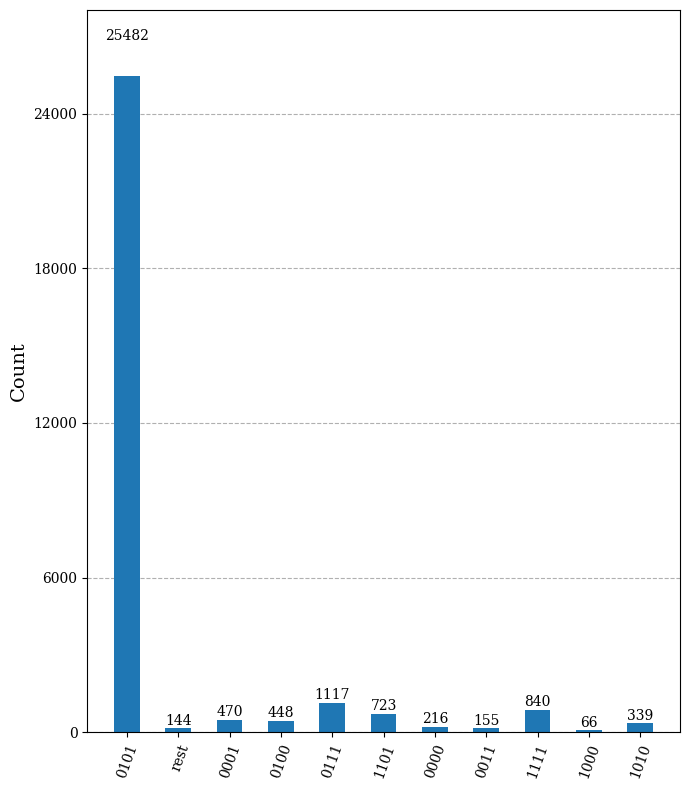

In [44]:
qiskit.visualization.plot_histogram(
    bit_array.get_counts(),
    target_string=hf_bitstring,
    sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    # ax=ax
    # filename="hf_ucj2.pdf",
)
# plt.tight_layout()
# plt.savefig("hf_ucj1.pdf")

## Post-process result.

In [45]:
energies = []
errors = []

for circuit in circuits:
    # SQD options
    energy_tol = 1e-5
    occupancies_tol = 1e-6
    max_iterations = 20
    rng = np.random.default_rng(1)

    # Eigenstate solver options
    num_batches = 2
    samples_per_batch = 1000
    symmetrize_spin = True
    carryover_threshold = 1e-4
    max_cycle = 200

    # Pass options to the built-in eigensolver. If you just want to use the defaults,
    # you can omit this step, in which case you would not specify the sci_solver argument
    # in the call to diagonalize_fermionic_hamiltonian below.
    sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

    # List to capture intermediate results
    result_history = []


    def callback(results: list[SCIResult]):
        result_history.append(results)
        iteration = len(result_history)
        print(f"Iteration {iteration}")
        for i, result in enumerate(results):
            print(f"\tSubsample {i}")
            print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
            print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


    result = diagonalize_fermionic_hamiltonian(
        hcore,
        eri,
        bit_array,
        samples_per_batch=samples_per_batch,
        norb=num_orbitals,
        nelec=nelec,
        num_batches=num_batches,
        energy_tol=energy_tol,
        occupancies_tol=occupancies_tol,
        max_iterations=max_iterations,
        sci_solver=sci_solver,
        symmetrize_spin=symmetrize_spin,
        carryover_threshold=carryover_threshold,
        callback=callback,
        seed=rng,
    )

    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    approx_energy = min(min_e)
    err = abs(min(min_e) - exact_energy)
    energies.append(approx_energy)
    errors.append(err)

Iteration 1
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4
Iteration 2
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4
Iteration 1
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4
Iteration 2
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4
Iteration 1
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4
Iteration 2
	Subsample 0
		Energy: -1.1011503302326187
		Subspace dimension: 4
	Subsample 1
		Energy: -1.1011503302326187
		Subspace dimension: 4


In [46]:
print(energies)
print(errors)

[np.float64(-1.1011503302326187), np.float64(-1.1011503302326187), np.float64(-1.1011503302326187)]
[np.float64(4.440892098500626e-16), np.float64(4.440892098500626e-16), np.float64(4.440892098500626e-16)]
